In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pims
from sklearn.preprocessing import MinMaxScaler
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, filters, measure, morphology
import math
import matplotlib.colors
import random
import os
import re
import pandas as pd
from ipywidgets import interact, widgets
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go





plt.rcParams['figure.dpi'] = 300
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):

    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## Input and output directory

In [3]:
input_path = '/home/diauro/Dropbox/Crystal Segmentation Rita-Raji-Diego/probability_masks/probabilities/better quality/new/2021-7-22_wt_56hpf_lysotracker1hSyto9-8h_9_PP_Probabilities'  # Input folder where images are selected

frames = pims.ImageSequence(input_path + '/*.tif') 

n_frames = len(frames)

save_folder = 'output_images' # folder that will be created inside 'input_path' folder
output_path = input_path + '/' + save_folder + '/'



image_names = os.listdir(str(input_path)) # Get images names for saving later
image_names = [sub.replace('.tif', '') for sub in image_names] # If you use tiff images don't change the '.tiff'
image_names.sort(key=natural_keys)


if os.path.exists(output_path) is False:
        os.makedirs(output_path , exist_ok=True)
        print('output directory created')
        
print("{} Frames loaded".format(len(frames))) 


20 Frames loaded


# Scale all the images:

In [4]:
def scaler(arr):

    unique = np.unique(arr)
    Max = max(unique)
    scaled = (arr/Max)*100

    return scaled



def scale_images(array):  
    """Function to scale the images
    
    Parameters
    ----------
    array : list of D images of size N x M  (D, N, M)
    can handle also images with two channels (D,C,N,M)
    
   
    Returns
    ----------
    
    array : list of D scaled images of size N x M (D,N,M)
    """

    scaled_images_max = []

    for j in range(len(frames)):
        image = frames[j]
        if len(np.shape(image)) == 2:
            scaled = scaler(image)
        elif len(np.shape(image)) == 3:
            image = image[:,:,0]
            scaled = scaler(image)
        else:
            print("please check image shape")
            break
        
        scaled_images_max.append(scaled)

    return  scaled_images_max

scaled_images_max = scale_images(frames)

size = np.shape(scaled_images_max[0]) #  To get the image size, first dimension size[0] = y-axis , size[1] = x-axis

## Check the images by modyfing the color scale 

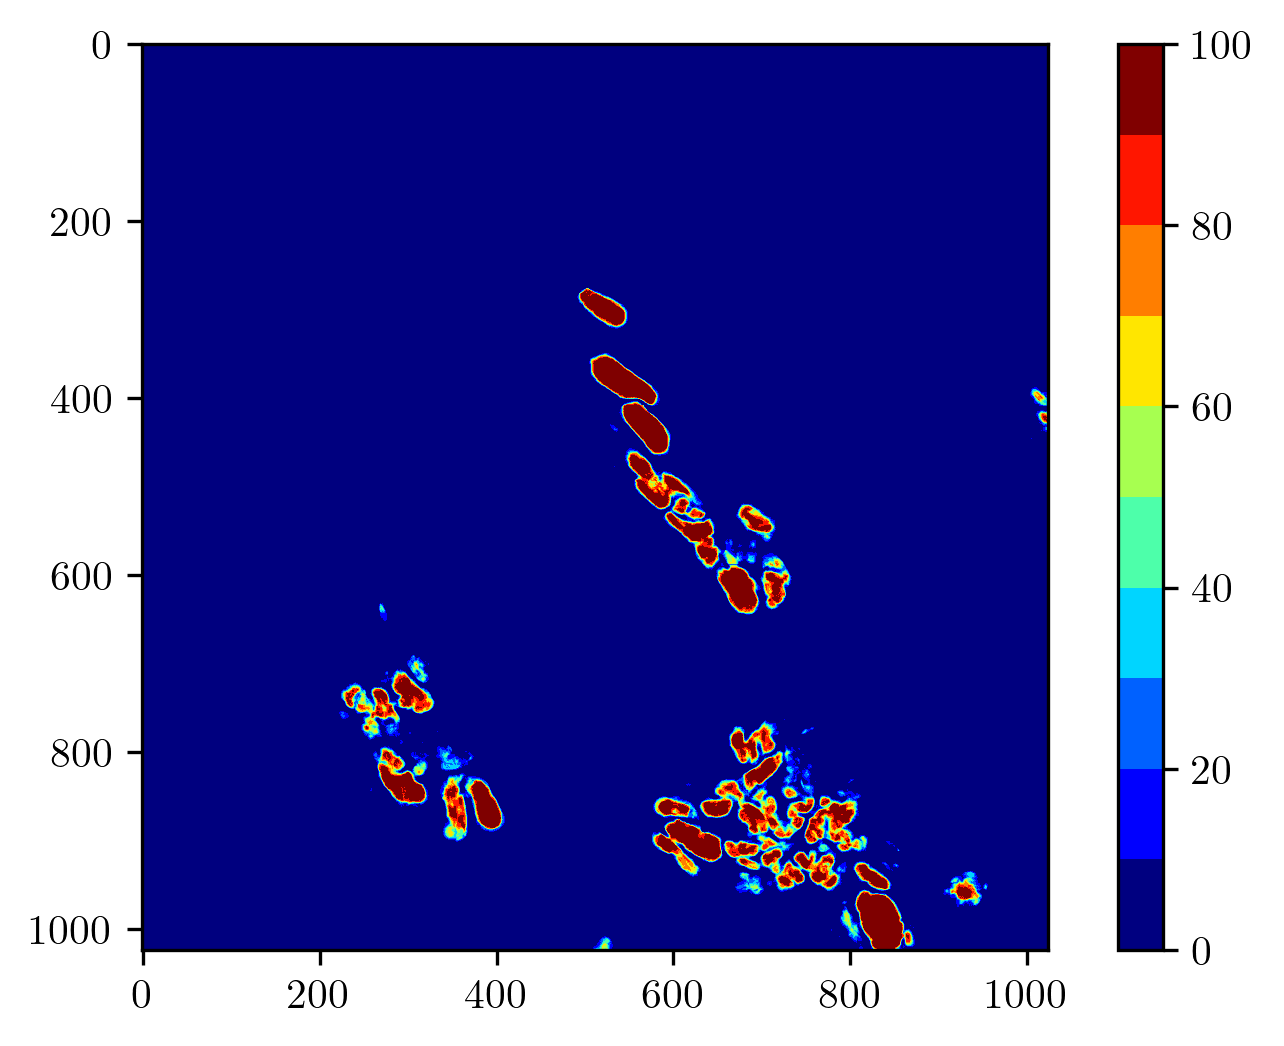

In [5]:
num_frame = 4    # Insert frame you want to inspect
Max = 100
image , Max = scaled_images_max[num_frame], Max



step = 10
N_bins = (100 // step) +1 

cmap = plt.cm.jet 
cmaplist = [cmap(i) for i in range(cmap.N) ]
colors = random.sample(cmaplist,N_bins)


cmap = matplotlib.colors.ListedColormap(cmaplist)
boundaries = np.arange(0, Max + step, step )
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)


plt.imshow(image, cmap=cmap, norm=norm)
plt.colorbar()

## Choose a treshold

In [ ]:
%%capture
%matplotlib inline



num_frame = 4   # Insert frame you want to inspect
image = scaled_images_max[num_frame]


temp_init = image
image_test = image



def test(image, tresh):

    temp = (image > tresh).astype(np.uint8)
    
    return temp



def f(Treshold):
    tresh = Treshold
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        #img_median = test(temp_int, tresh)
        img_median = (temp_init > Treshold).astype(np.uint8)
    
    ax_neu.imshow(img_median, cmap=cmap)
    ax_neu.imshow(image, cmap='gray',alpha=0.4)
    
    fig.canvas.draw()
    display(fig)




fig = plt.figure(figsize=(30, 15))
#ax_orig = fig.add_subplot(121) 
ax_neu = fig.add_subplot(122) 

#ax_orig.imshow(image, cmap=cmap, norm=norm)
ax_neu.imshow(image_test, cmap=cmap,norm=norm)

In [ ]:
interact(f, Treshold=widgets.IntSlider(min=1,max=100,step=2,value=90));

## Insert the number of thresholds:

Select the first value then press enter and so on, once you are done just click enter


In [6]:
try:
    tresholds = []
     
    while True:
        tresholds.append(int(input()))
         
# if the input is not-integer, just print the list
except:
    print(tresholds)
    

80

[80]


# For loop to process a sequence of images
- Select the minimum amount of pixels "min_pix" and maximum amount of pixels to keep "max_pix ".

## The properties are stored inside the respective folders in a excel file.
- "df_final" contains all the measured region properties
- "df_clean" contains all the 

In [10]:
min_pix = 200
max_pix = 2000


list_images = []
list_all_images = []
list_df_clean = []
list_save_dir = []

for tresh in tresholds:
    temp = 'tresh_' + str(tresh)
    
    out_path_cls_tresh = output_path + '/' + temp
    list_save_dir.append(out_path_cls_tresh)
    
    if os.path.exists(out_path_cls_tresh):
        pass
    else:  
        os.makedirs(out_path_cls_tresh, exist_ok=True)
        
    list_prop = []    
    for frame in range(len(scaled_images_max)) :           # range(len(list_arr))scaled_images_max
        
        
        image = scaled_images_max[frame]                                           #list_arr[frame]
        image = (image > tresh).astype(np.uint8)                         # below 72 h 50 - 3000  , above 72h 200-3000
        list_images.append(image)
        label_img = label(image)
        regions = regionprops(label_img)

        props = regionprops_table(label_img, properties=('centroid','bbox',
                                                     'orientation',
                                                     'major_axis_length',
                                                     'minor_axis_length','area','perimeter','coords','image'))
        df_prop = pd.DataFrame(props)
        suffix = "frame_" + str(frame) + "_"

        df_save = df_prop.set_index( suffix + df_prop.index.astype(str)  )
        list_prop.append(df_save)

        
    
    df_final = pd.concat(list_prop)       # Create unique dataframe
    
    df_clean = df_final.copy()
    df_clean = df_clean.drop(df_clean[(df_clean['area'] < min_pix) | (df_clean['area'] > max_pix)].index)

    list_all_images.append(list_images)    
    list_df_clean.append(df_clean)   



        
    #df_final = pd.concat(list_prop)                                        # Create unique dataframe
    df_final.to_excel(out_path_cls_tresh + '/' + temp + "_output.xlsx")      # Save it 
    df_clean.to_excel(out_path_cls_tresh + '/' + temp + "_output_clean.xlsx")
    



# Reconstruct images from dataframes:


In [11]:
def reconstruct_df(df):
    """ Function to reconstructy the region properties in a 2D array starting 
        from the dataframe created in the main loop
        
        Parameters
        ----------
        DataFrame : Expects a dataframe with indices and region properties
        created in the previous loop. The function accesses the coordinates of each area 
        and reconstructs 
        
        Returns
        ----------
        array : 2D array of the corresponding regions obtained by the regionprops
        in skimage
    
    """

    array = np.zeros((size[0], size[1]))
    for i in range(len(df)):
        coords = df['coords'][i]
        y, x = coords[:,0],coords[:,1] 
        yx = zip(y,x)

        for j, coord in enumerate(yx):
            array[coord] = i+10
    return array  

def plot_reconstruct(df_list,num_frame, image_names, save_dir=list_save_dir, save='no'):
    """ Function to plot the filtered region properties and save them inside a folder  

    Parameters
    ----------
    List of DataFrames (df_list) : Expects a list of dataframes with indices and region properties
    created in the previous loop. The data frames are passed to the reconstruct_df function 

    image_names : list of string names of the files in the current folder (this is created
    at the beginning of the script)
    
    save_dir : list of saving directories. (This is stored in the "list_save_dir")
    
    save : optional parameter normally set to "no". When calling the function you can decide to save 
    the images by setting save = 'yes'

    Returns
    ----------
    array : list of 2D array of the corresponding to the images of the regionprops (they are in the
    list "list_rec_images" )
    
    images : images are saved in the directories as .jpg files
    
    """
    
    list_rec_images = []
   
    for df in range(len(df_list)):
        df_temp = df_list[df]
        saving = save_dir[df] 


        for i in range(num_frame):

            df_temp = df_clean[df_clean.index.str.contains('frame_'+ str(i) + '_')]

            fig, ax = plt.subplots()

            image = reconstruct_df(df_temp)
            
            ax.imshow(image, cmap=plt.cm.jet)


          
            for (idx, row) in df_temp.iterrows():

                index = idx.replace('frame_'+ str(i) + '_',"")

                y0, x0 = row.loc['centroid-0'], row.loc['centroid-1']
                orientation = row.loc['orientation']
                x1 = x0 + math.cos(orientation) * 0.5 * row.loc['minor_axis_length']
                y1 = y0 - math.sin(orientation) * 0.5 * row.loc['minor_axis_length']
                x2 = x0 - math.sin(orientation) * 0.5 * row.loc['major_axis_length']
                y2 = y0 - math.cos(orientation) * 0.5 * row.loc['major_axis_length']

                ax.plot((x0, x1), (y0, y1), '-r', linewidth=0.5)
                ax.plot((x0, x2), (y0, y2), '-r', linewidth=0.5)
                ax.plot(x0, y0, '.g', markersize=2)

                minr, minc, maxr, maxc = row.loc['bbox-0'],row.loc['bbox-1'],row.loc['bbox-2'],row.loc['bbox-3']
                bx = (minc, maxc, maxc, minc, minc)
                by = (minr, minr, maxr, maxr, minr)
                ax.plot(bx, by, '-b', linewidth=0.7)
                ax.text(bx[0]-5, by[0]-5, index, color='Red', size = 4)

            ax.axis((0, size[0], size[1], 0))
            list_rec_images.append(image)
            if save == 'yes':
                plt.savefig(os.path.join(saving, image_names[i] + "_.jpg" ),  dpi=200 ,bbox_inches='tight')
            else:
                pass
    return list_rec_images        

# Plotting all the tresholds

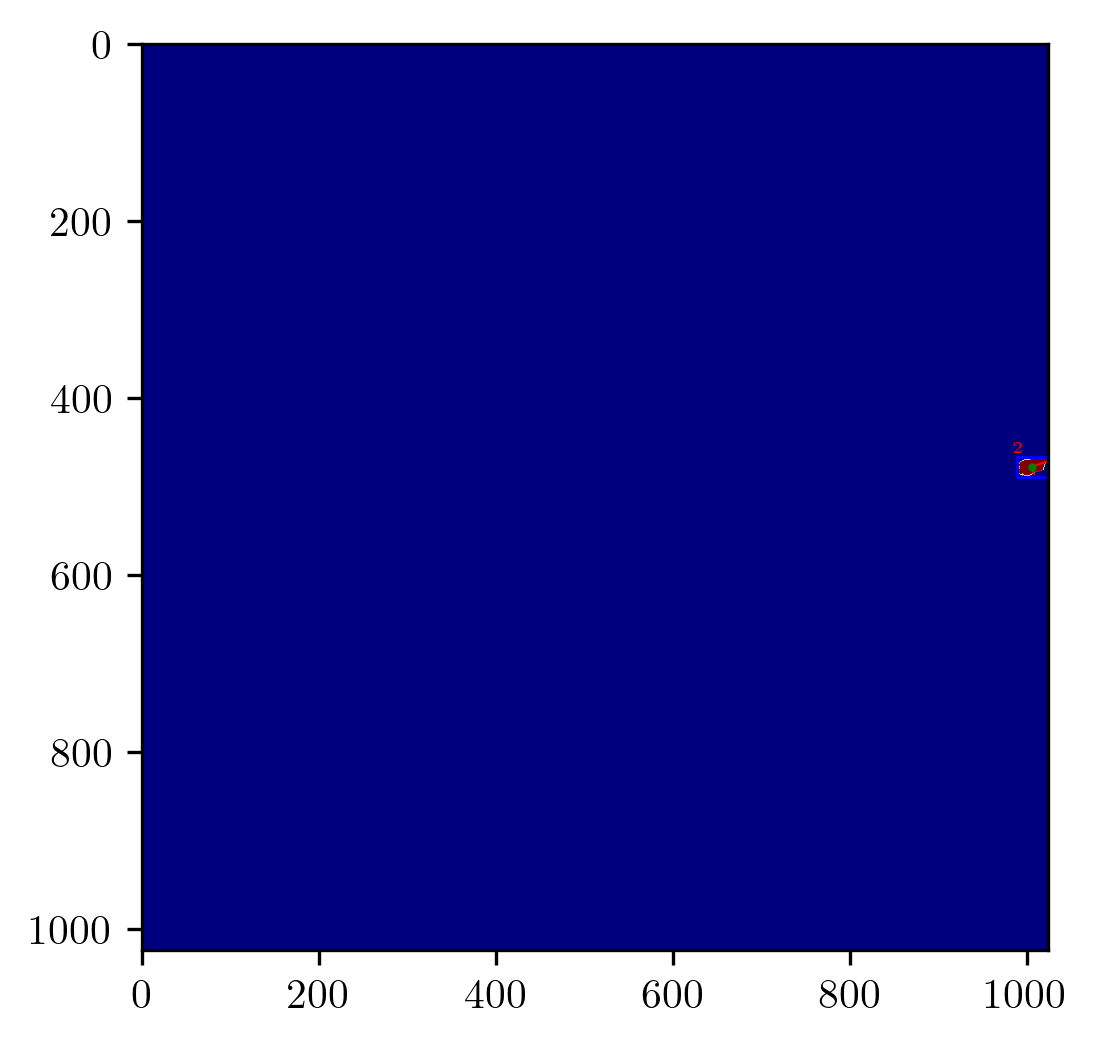

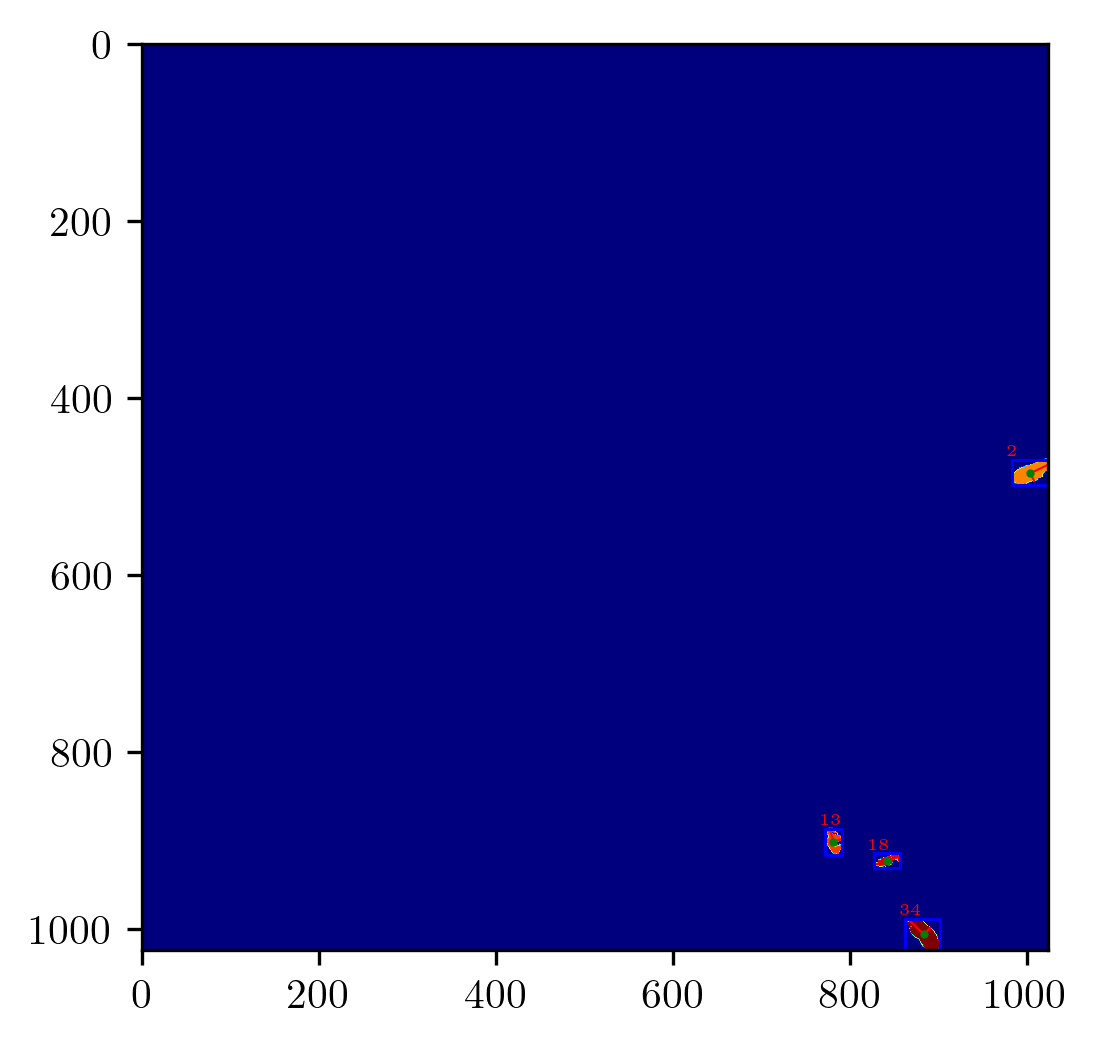

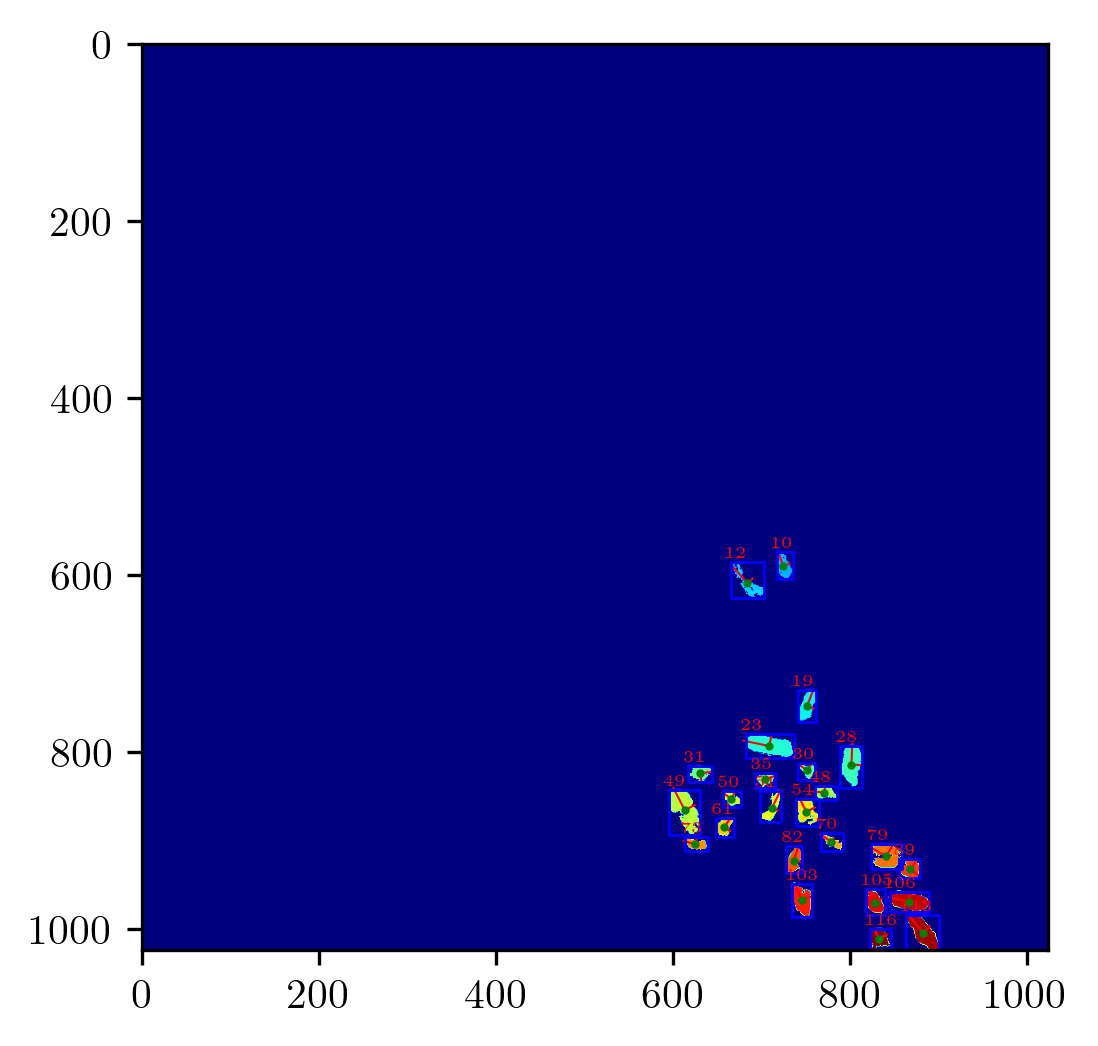

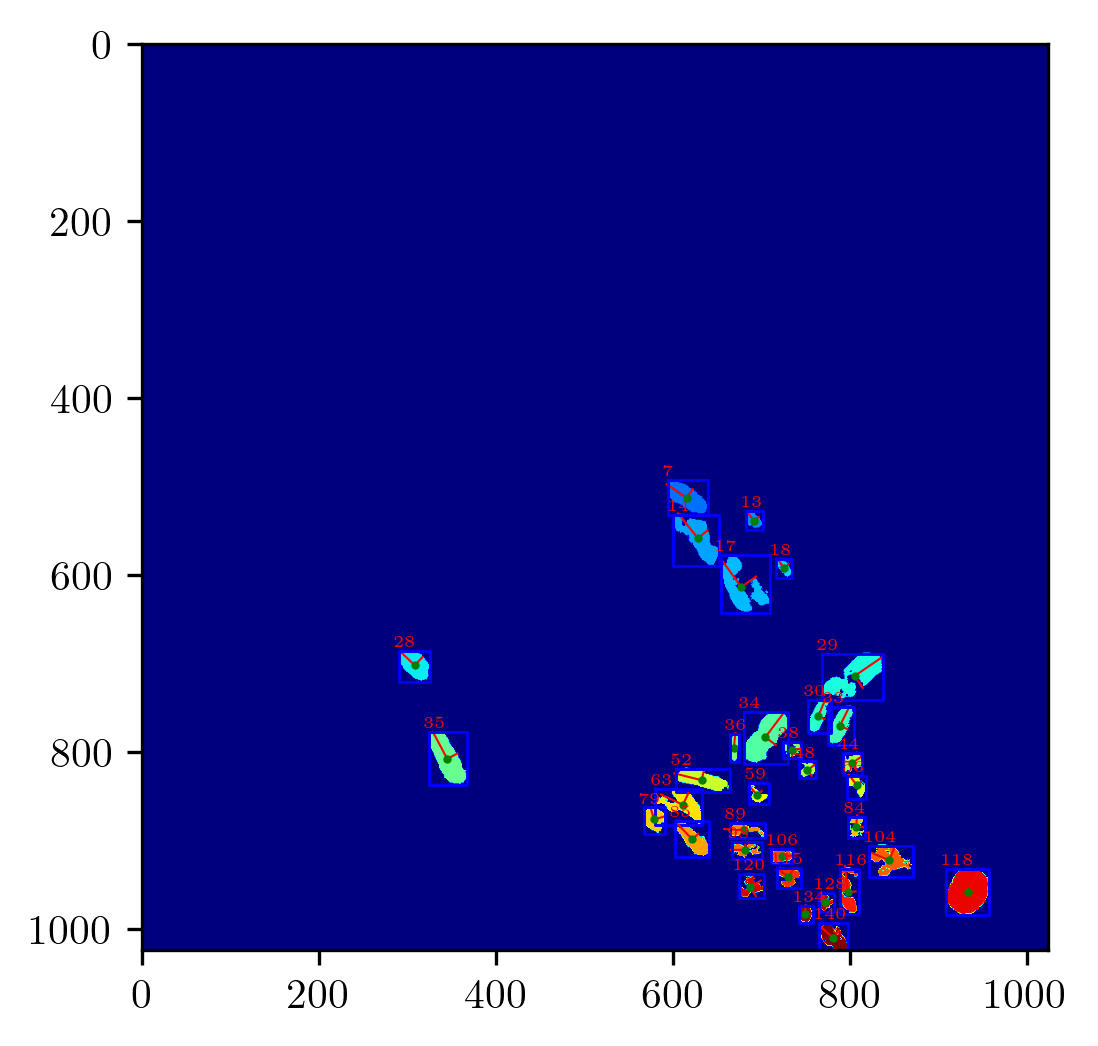

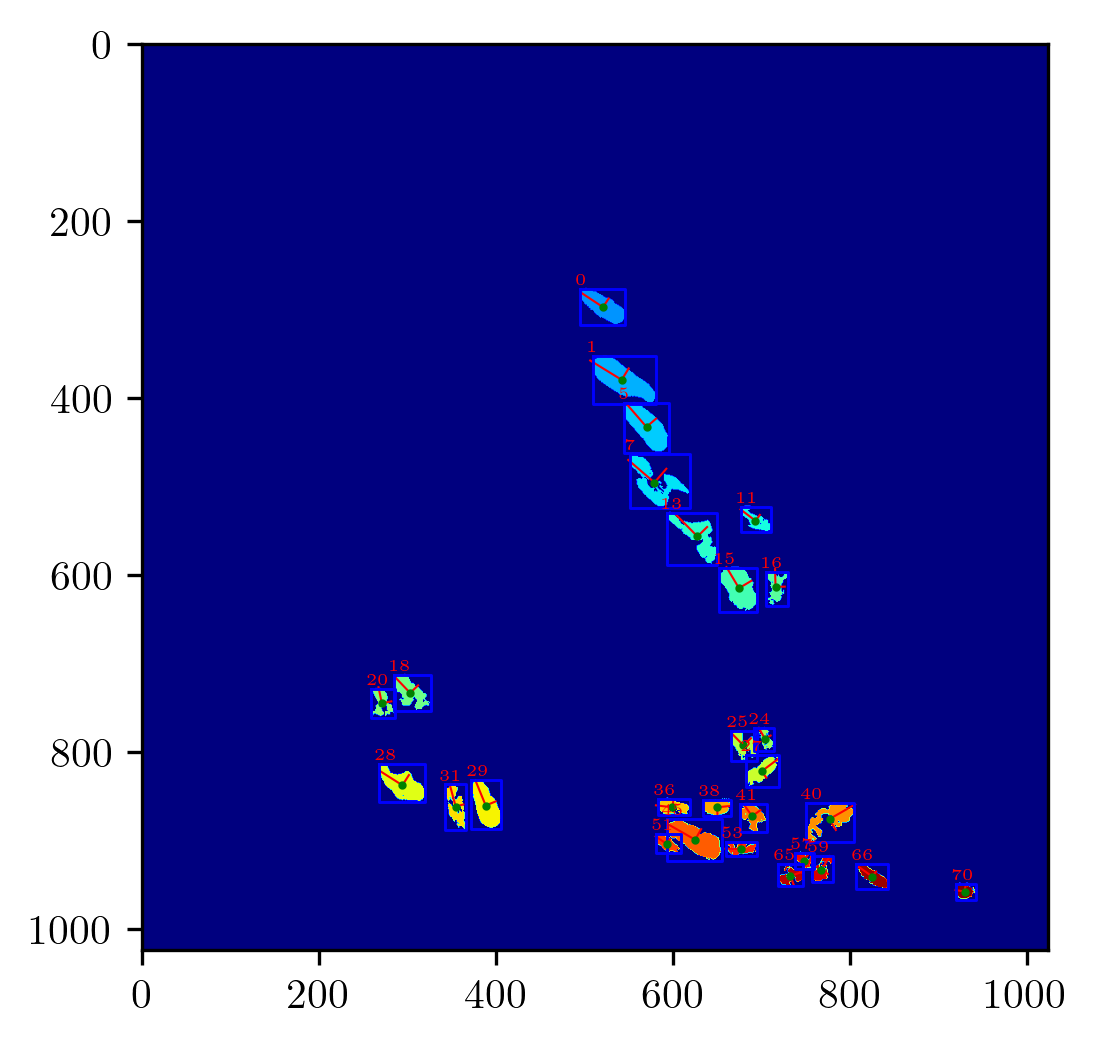

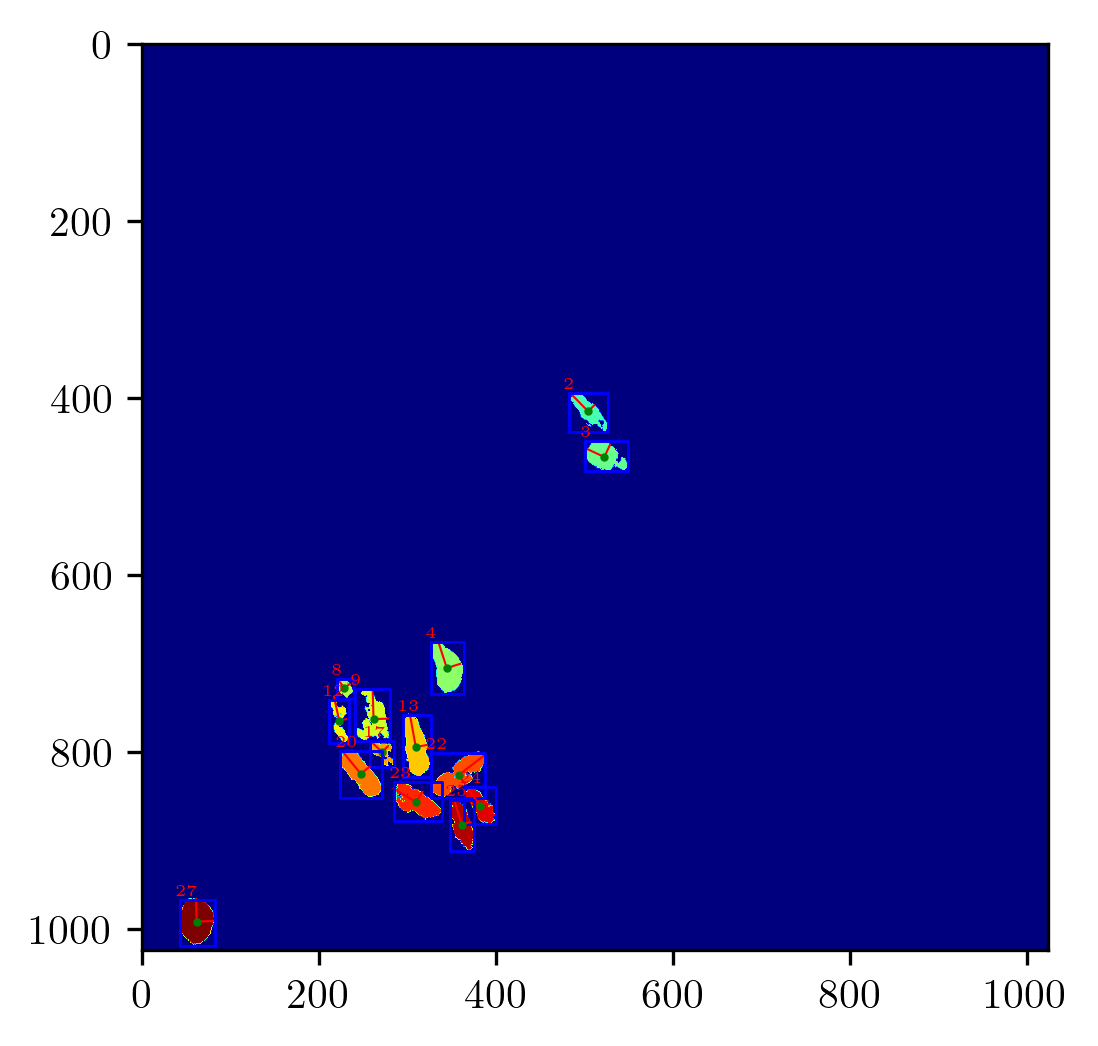

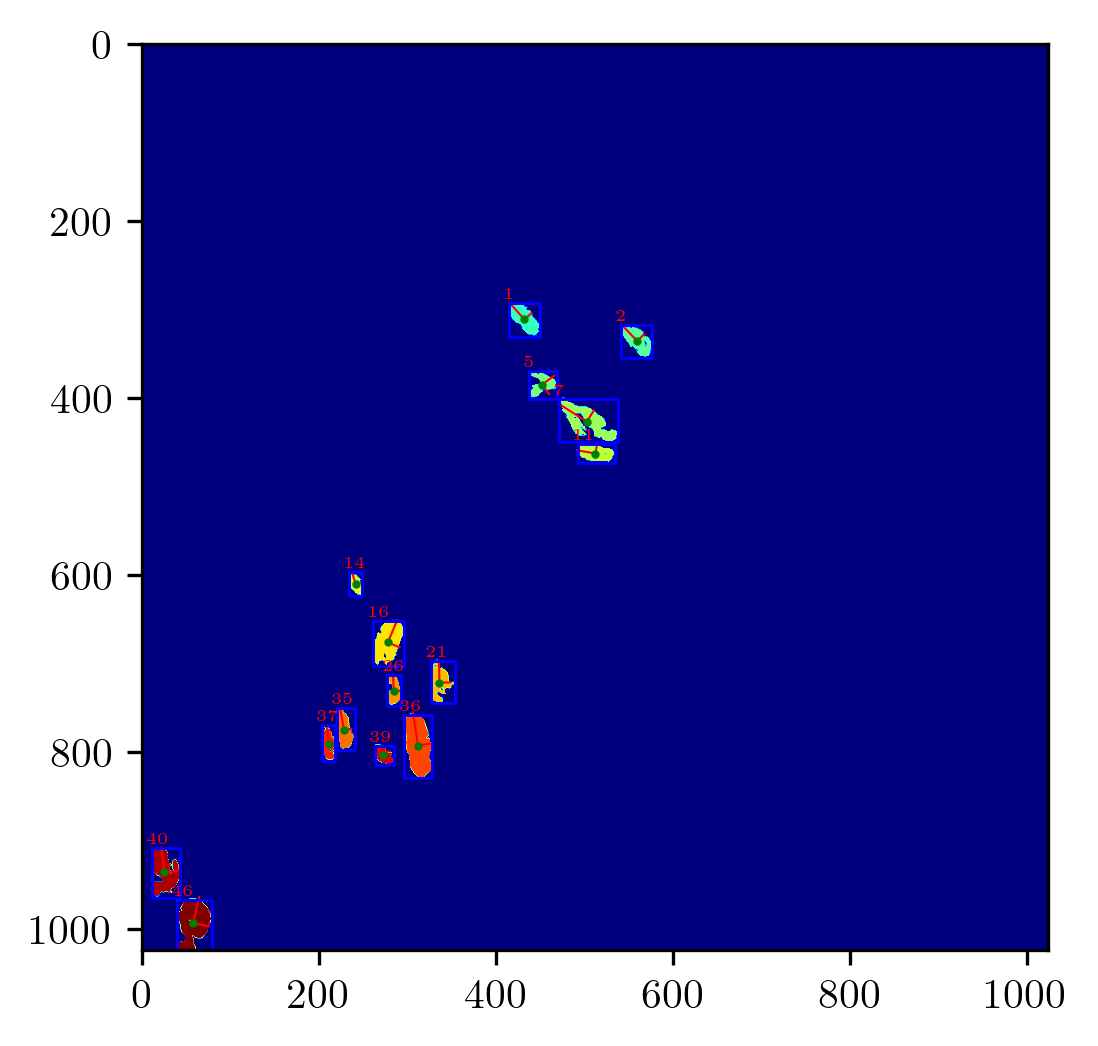

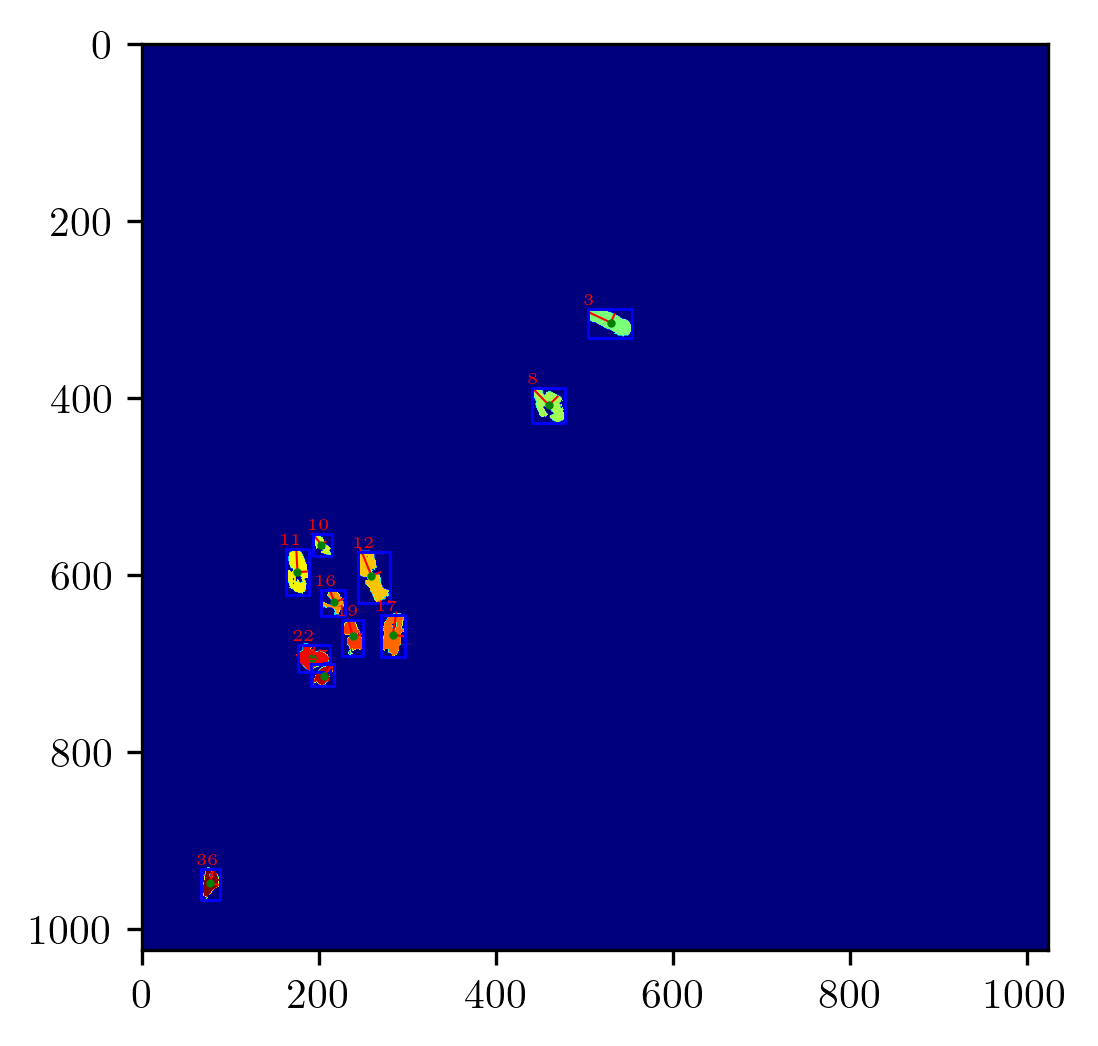

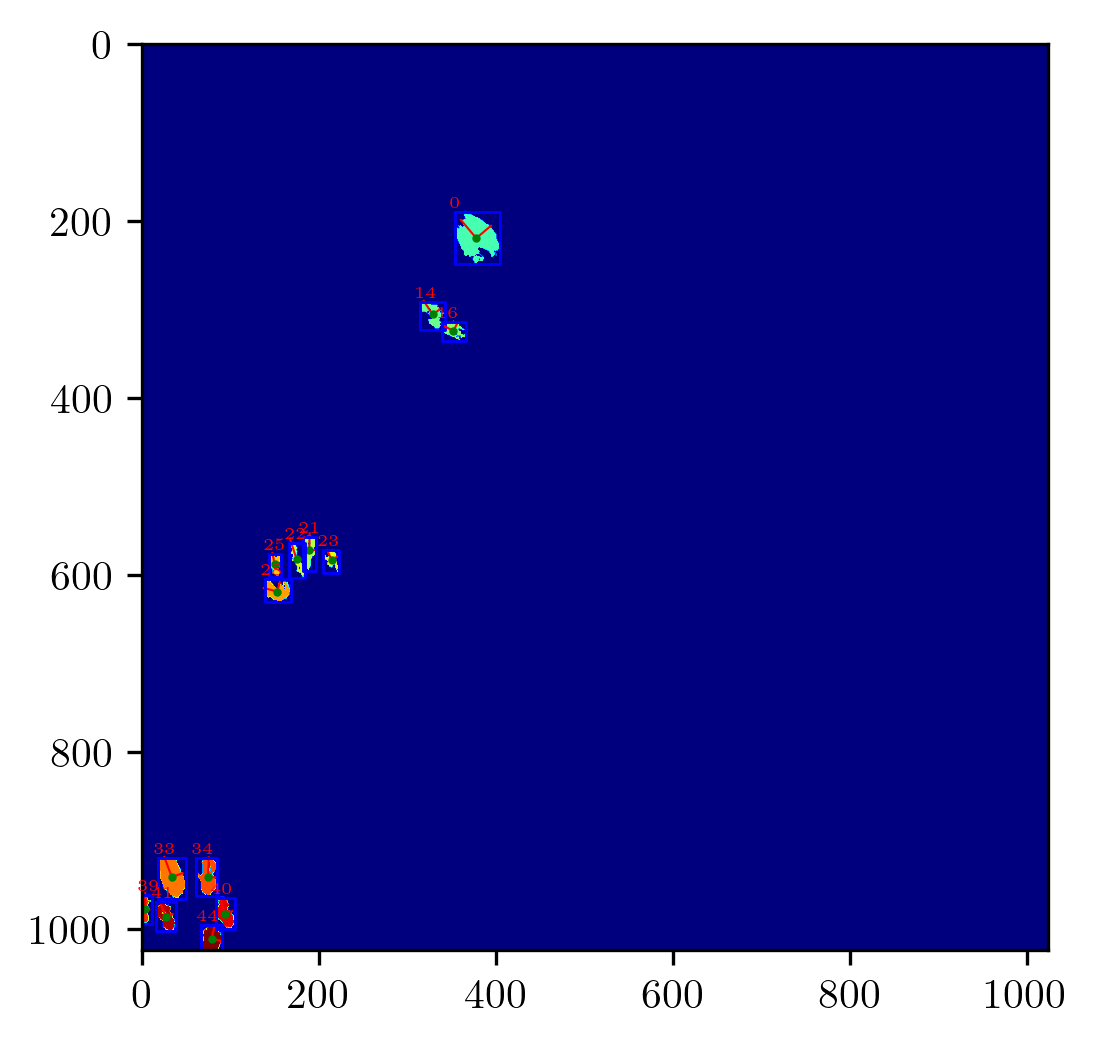

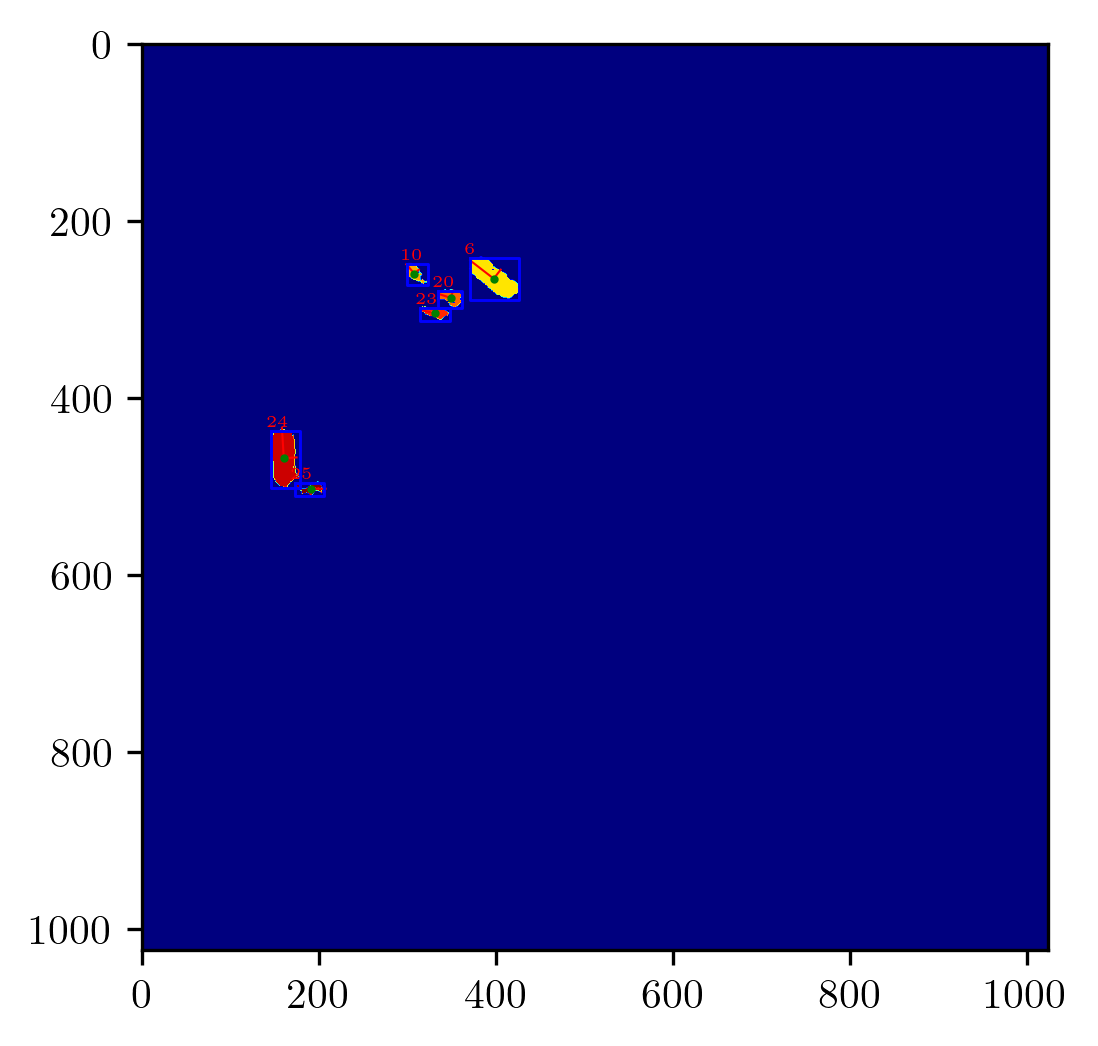

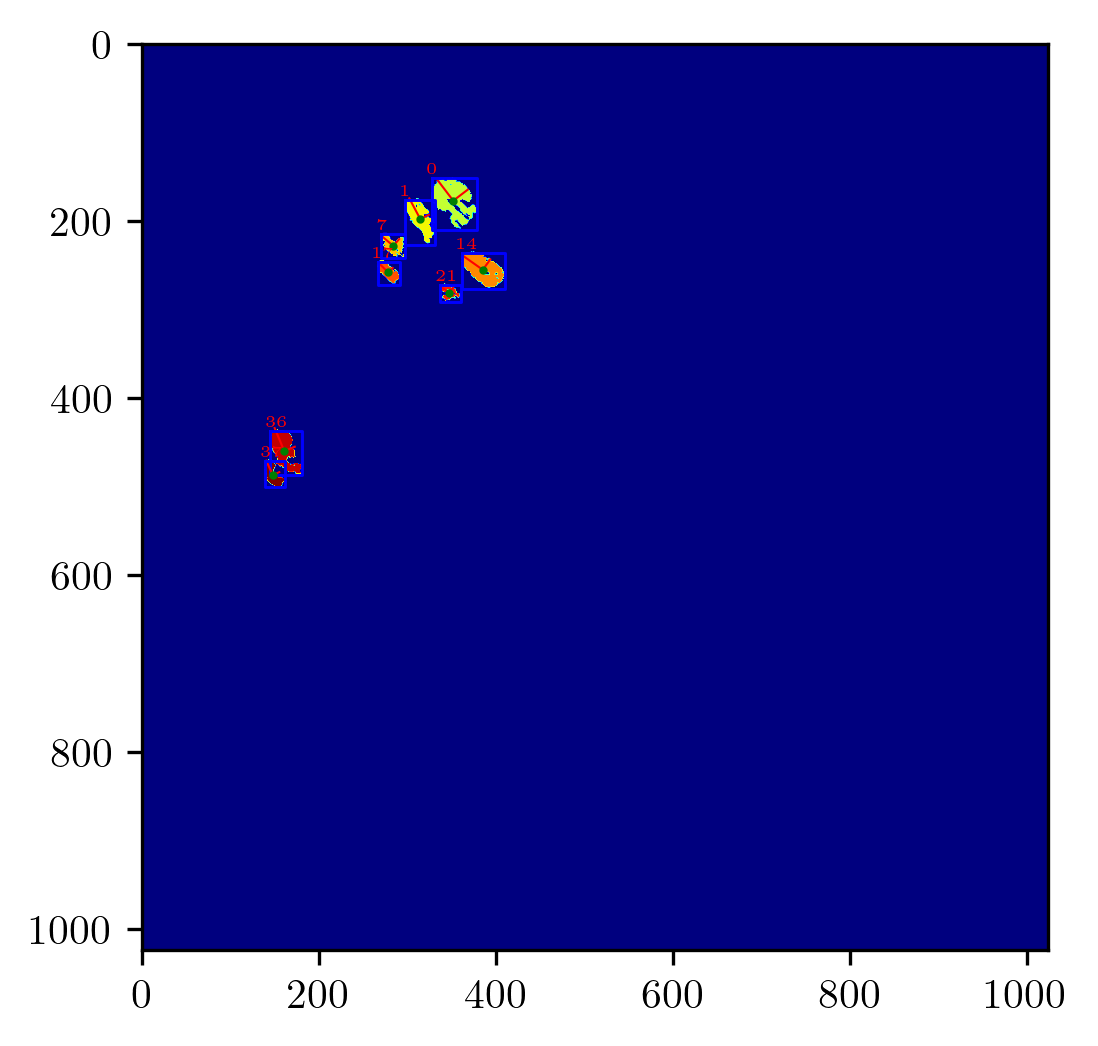

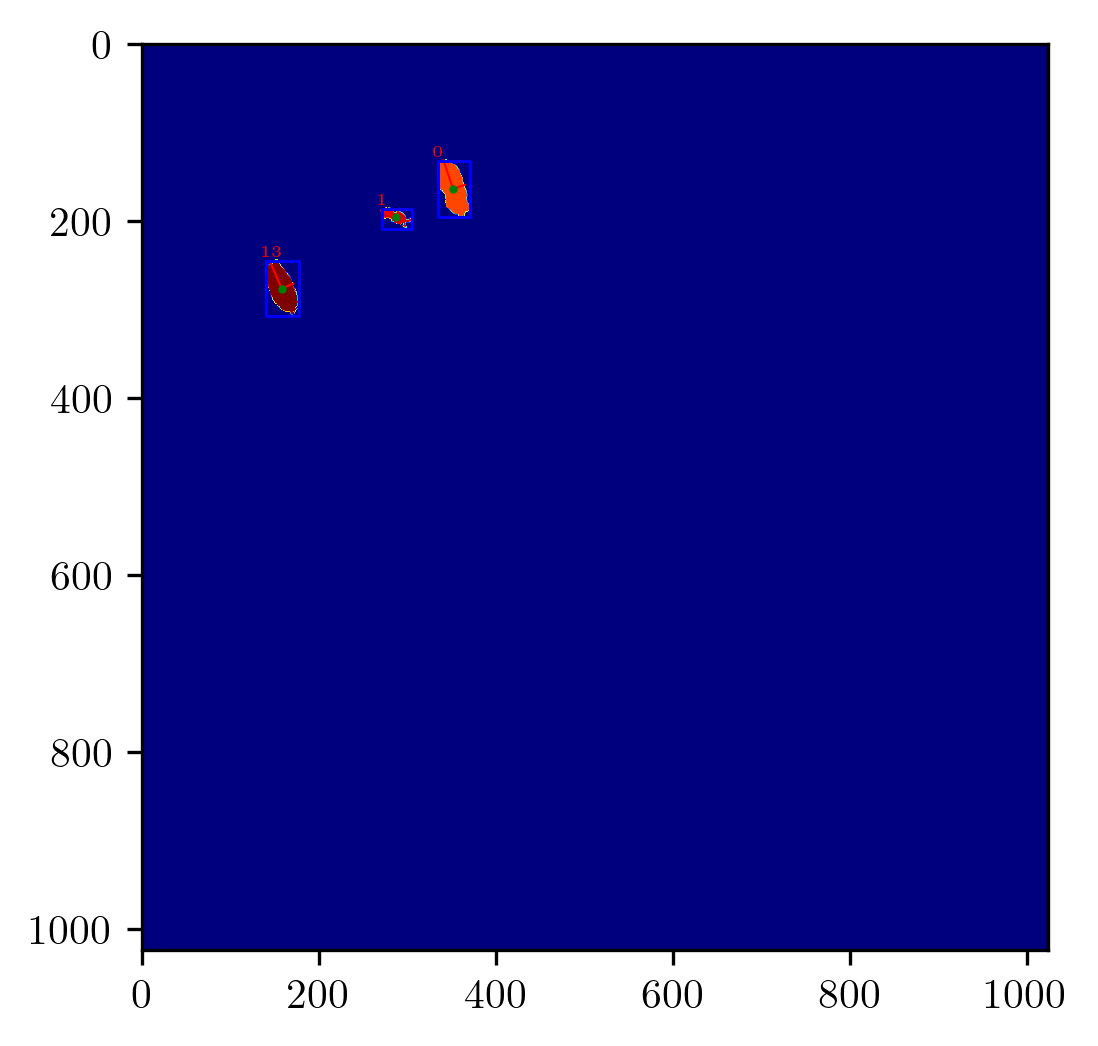

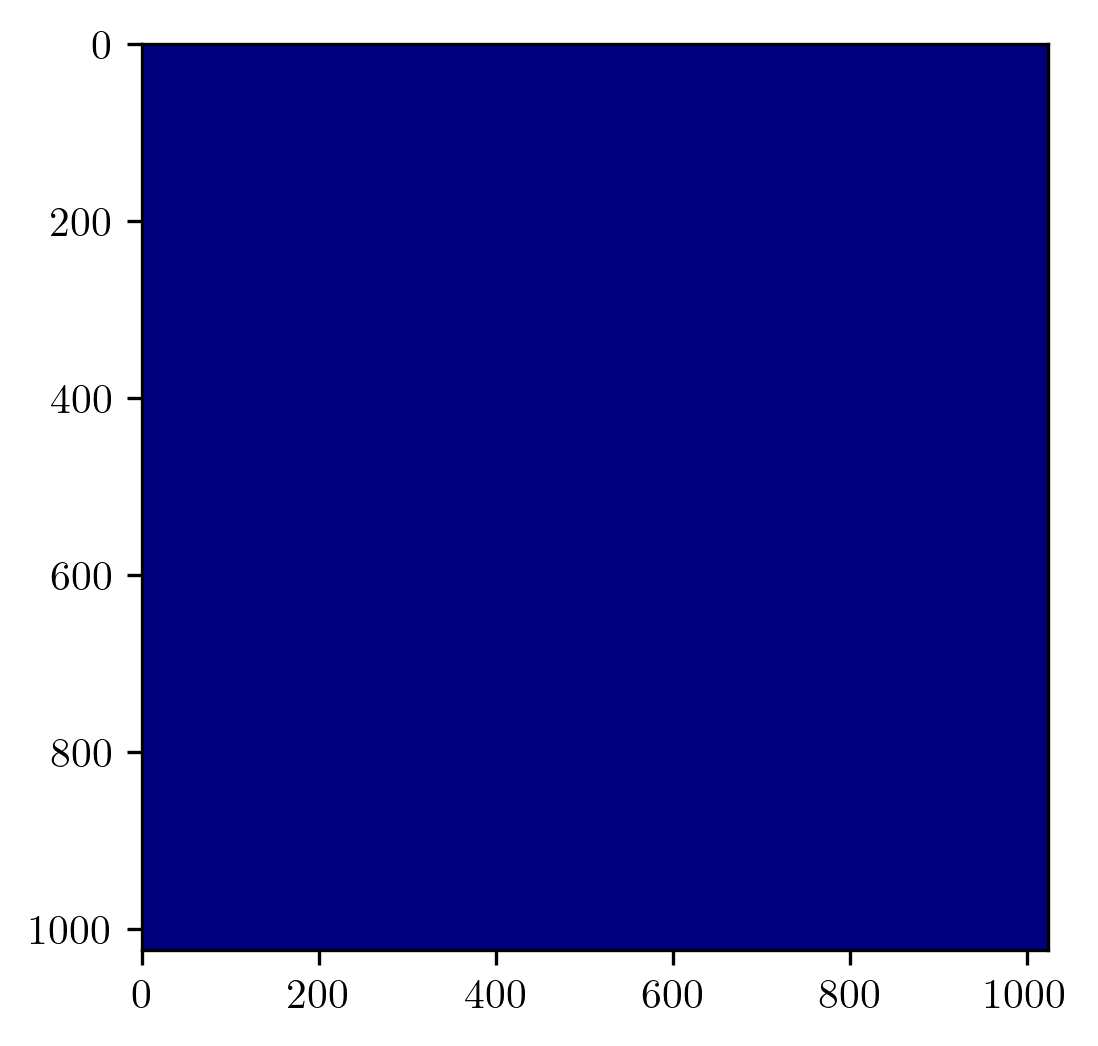

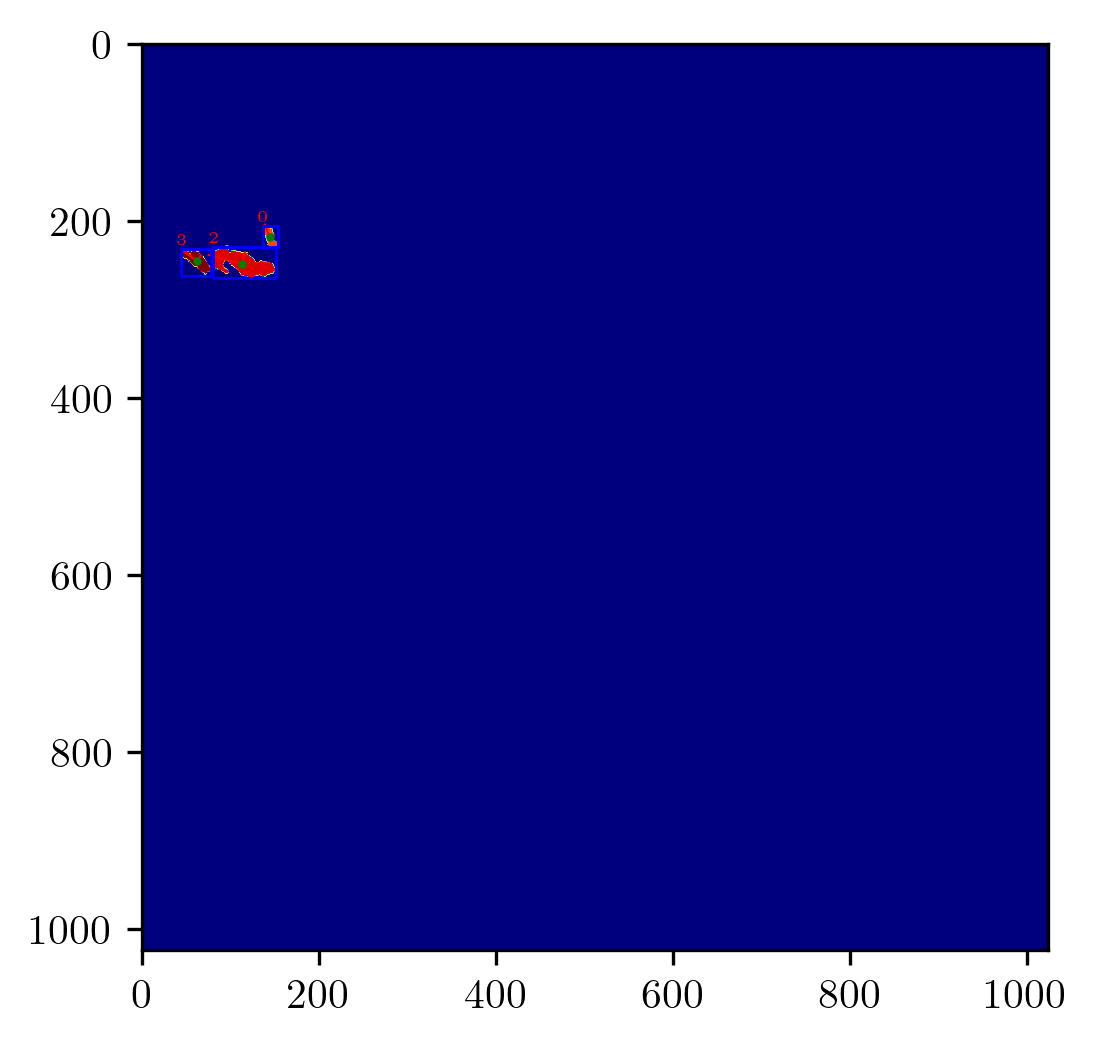

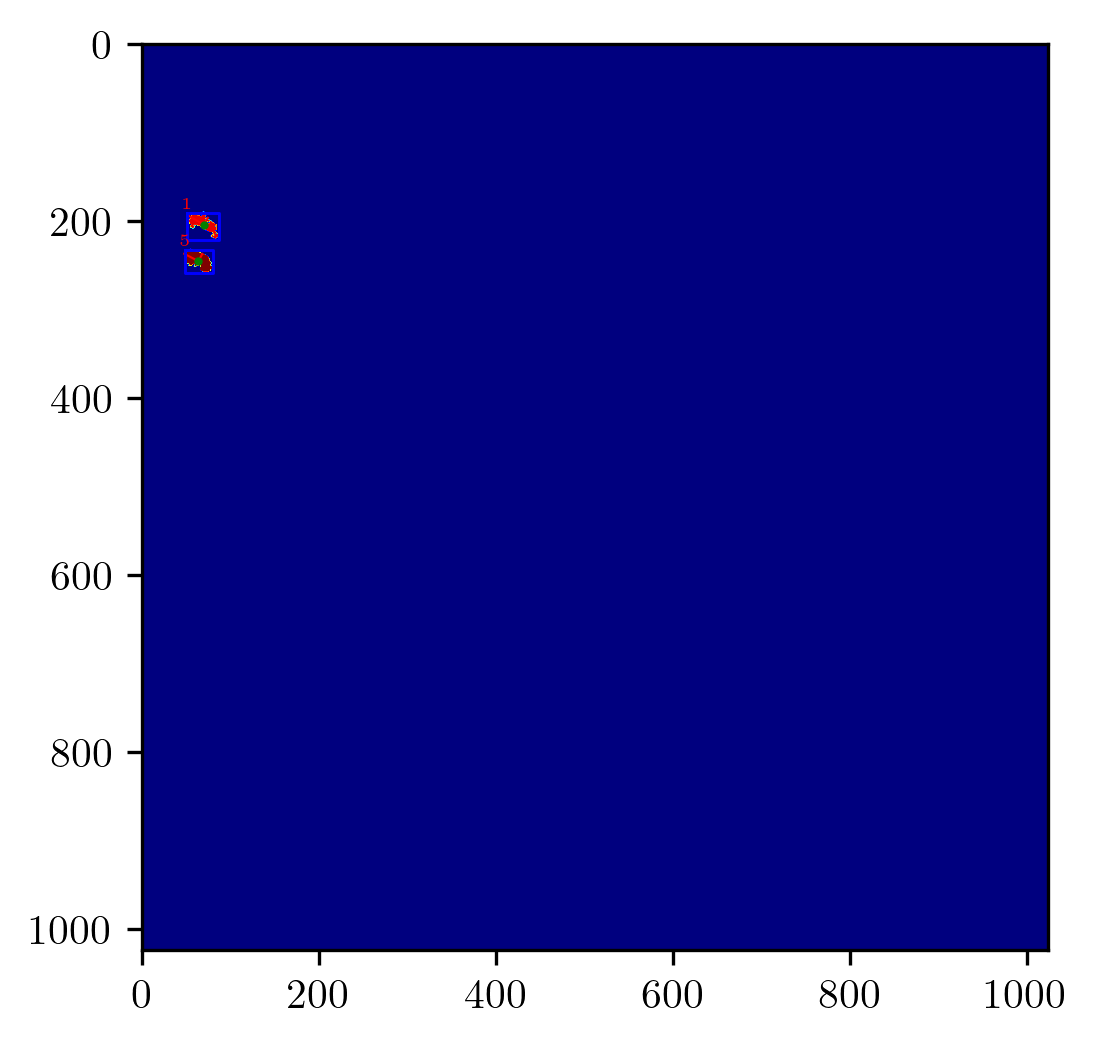

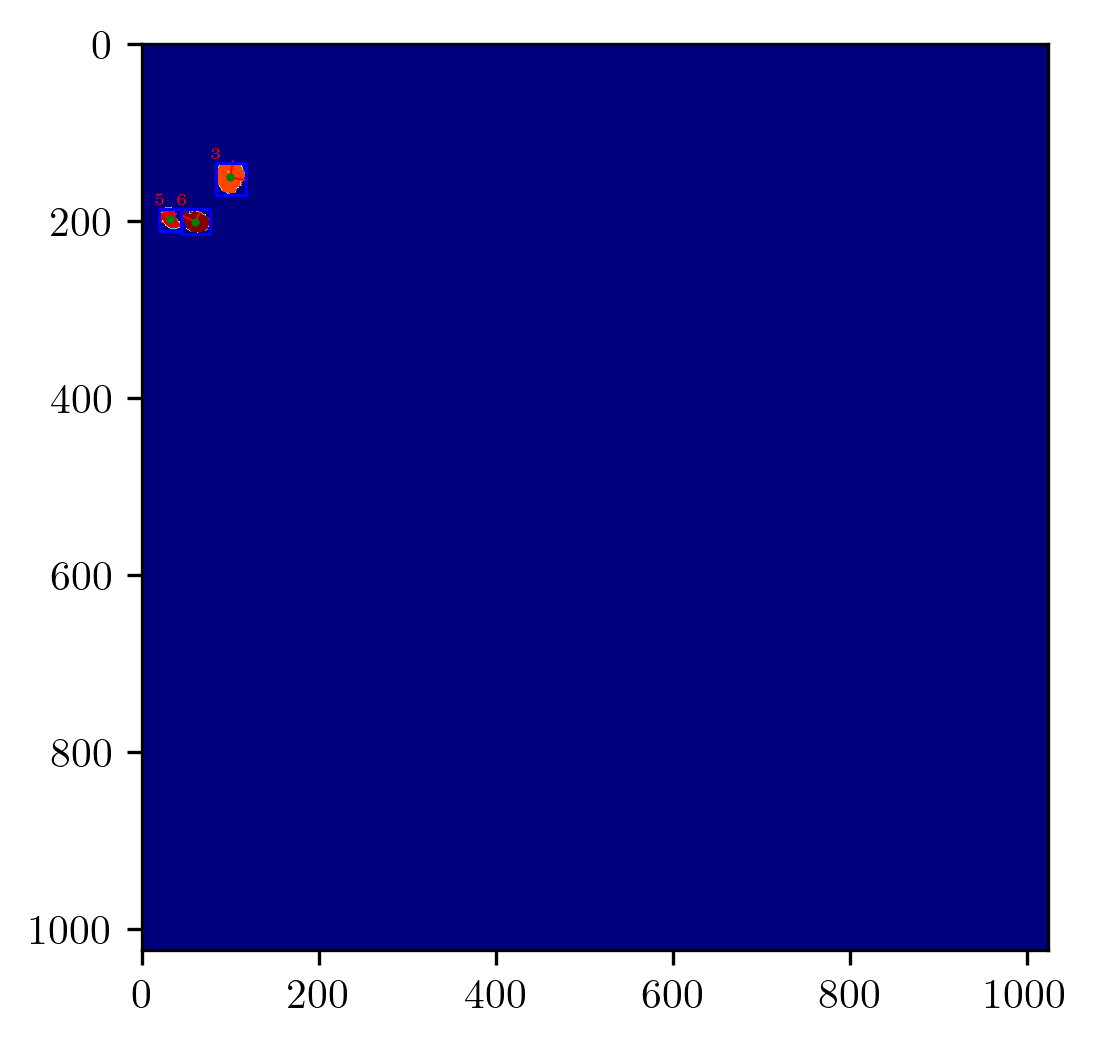

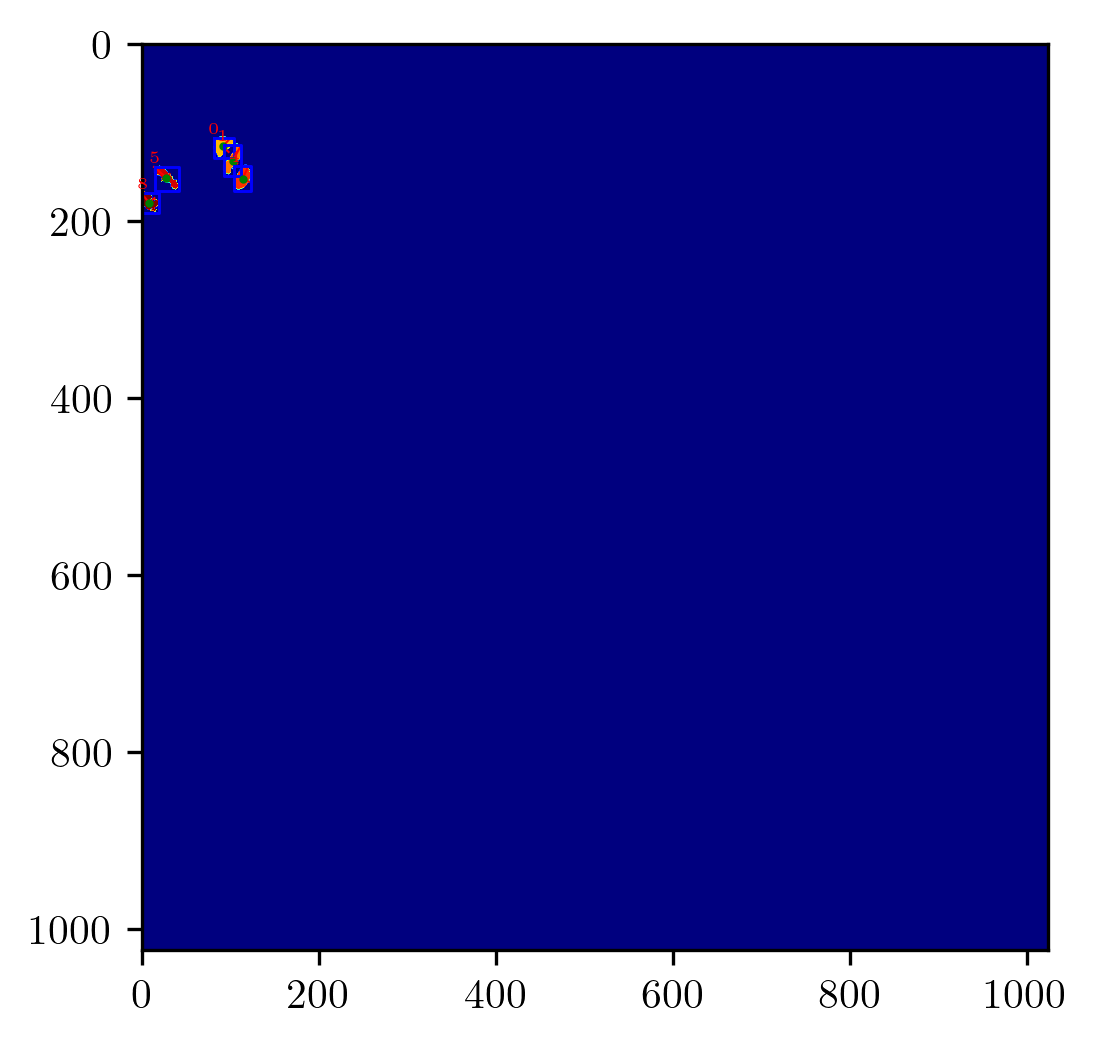

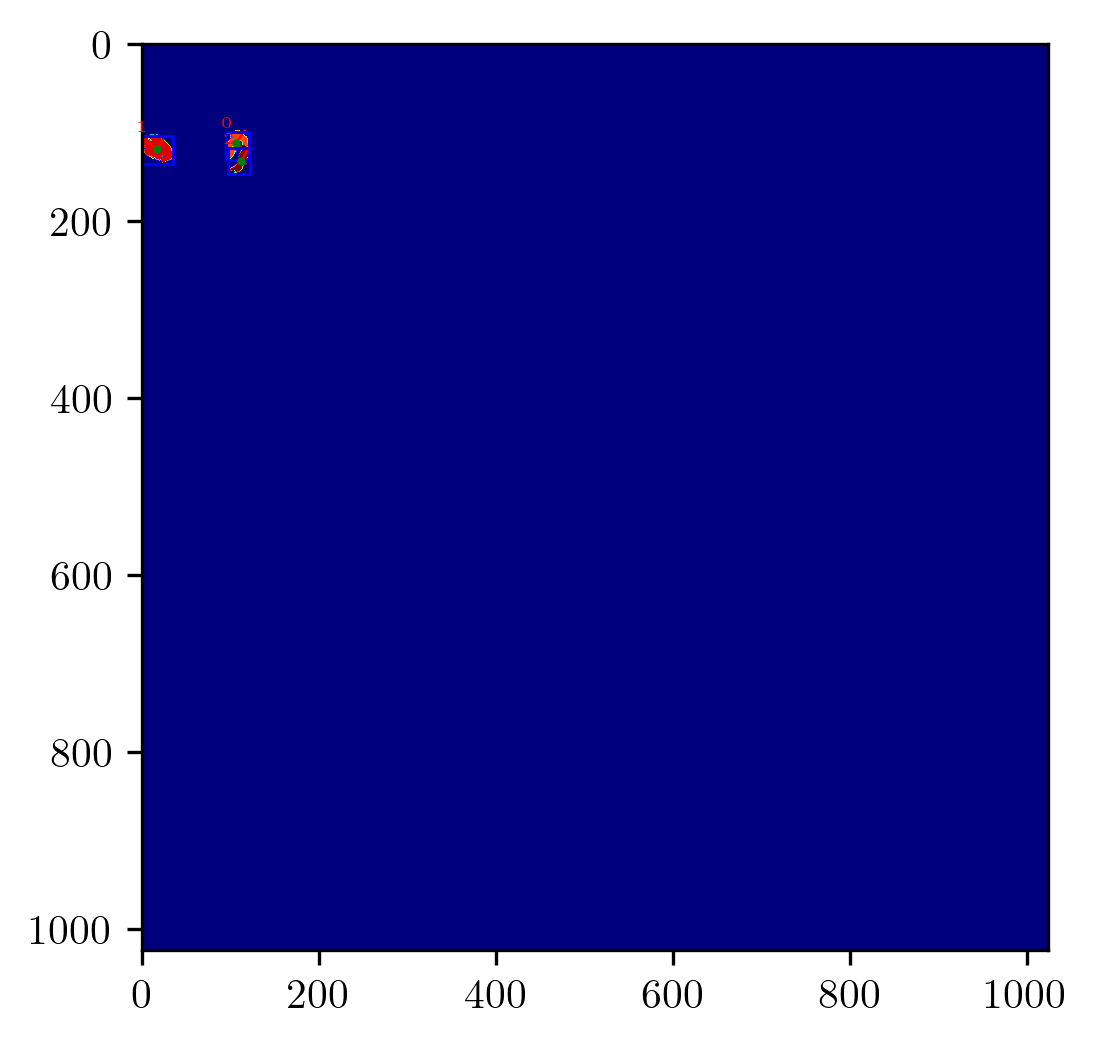

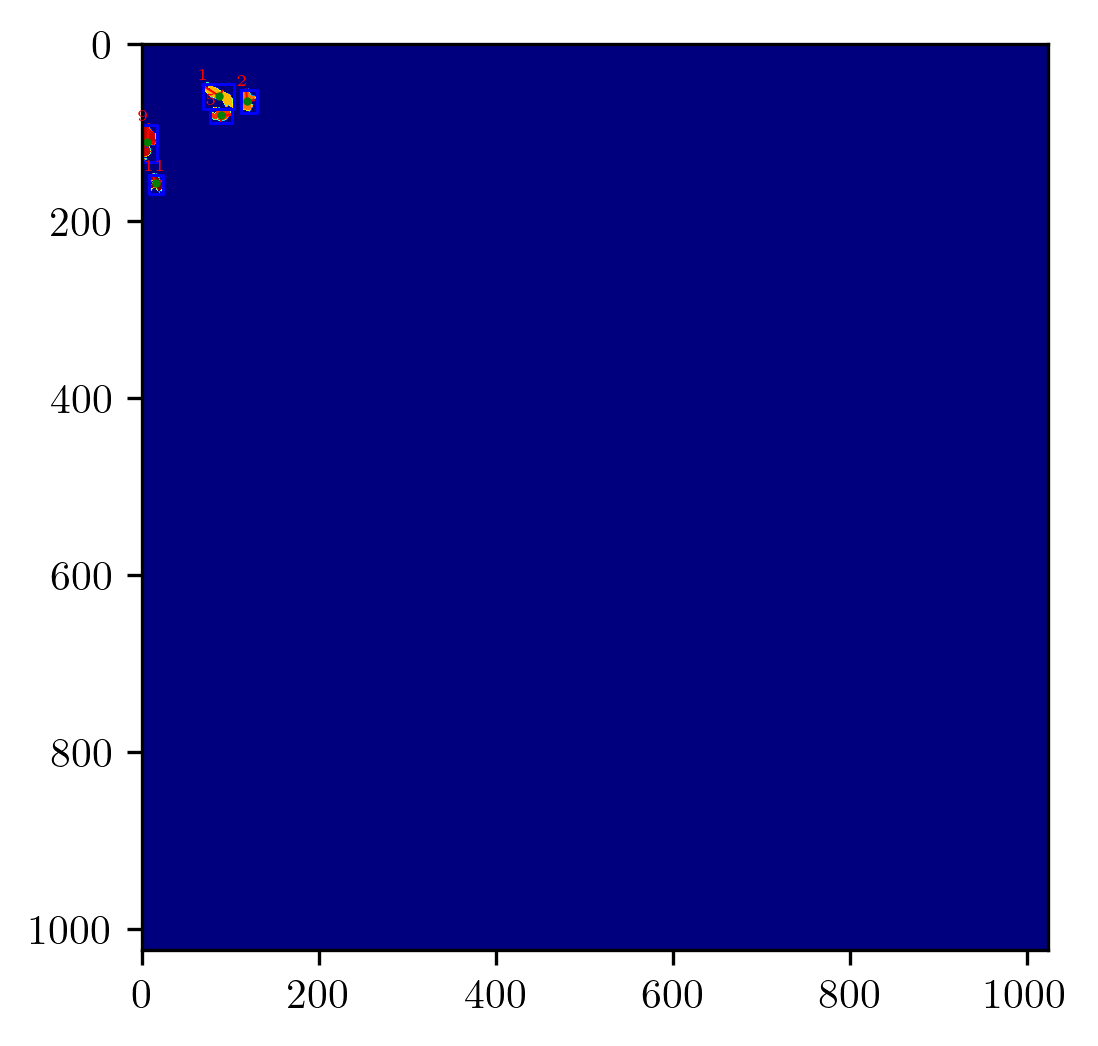

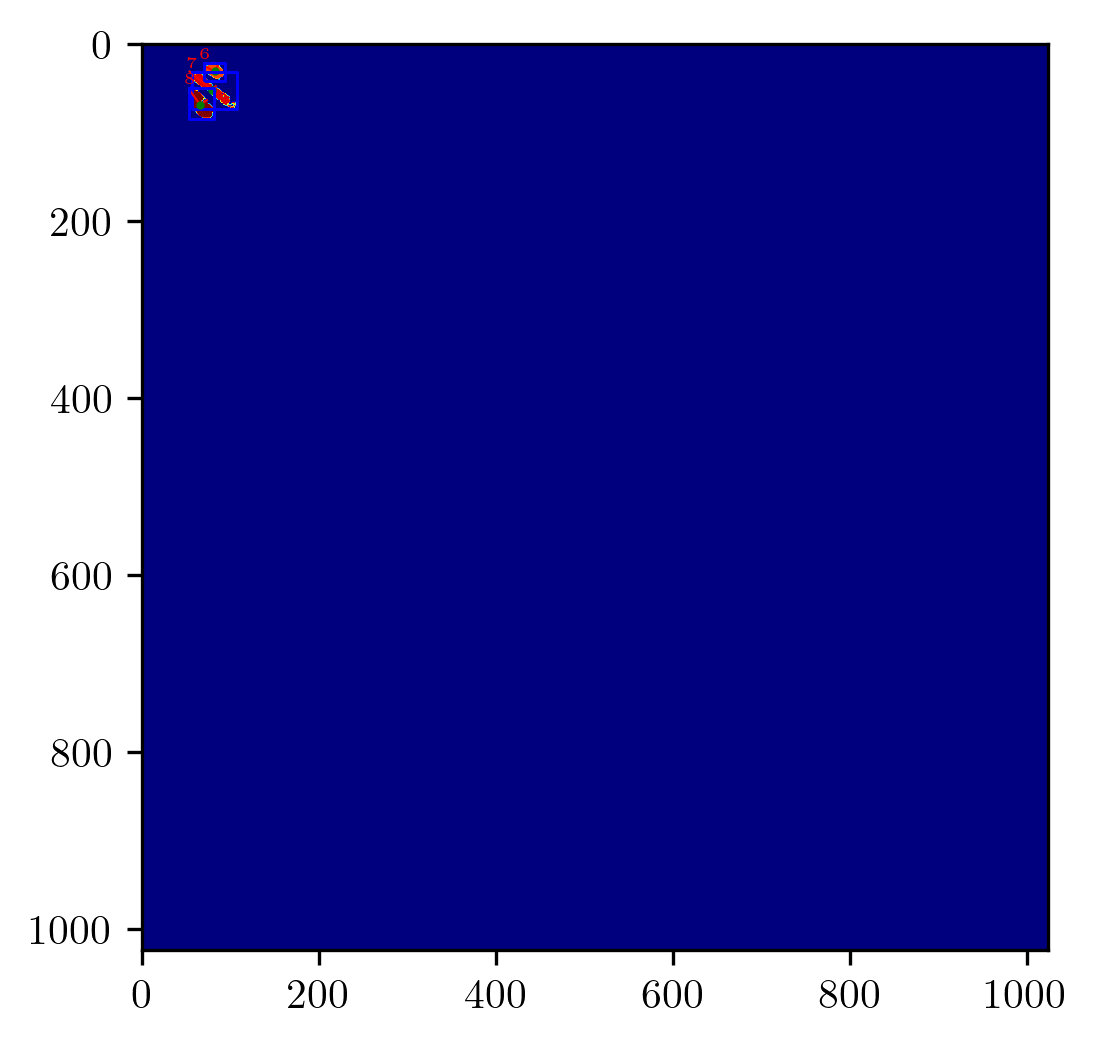

In [12]:
plots = plot_reconstruct(list_df_clean, n_frames, image_names=image_names, save_dir=list_save_dir , save='yes' )

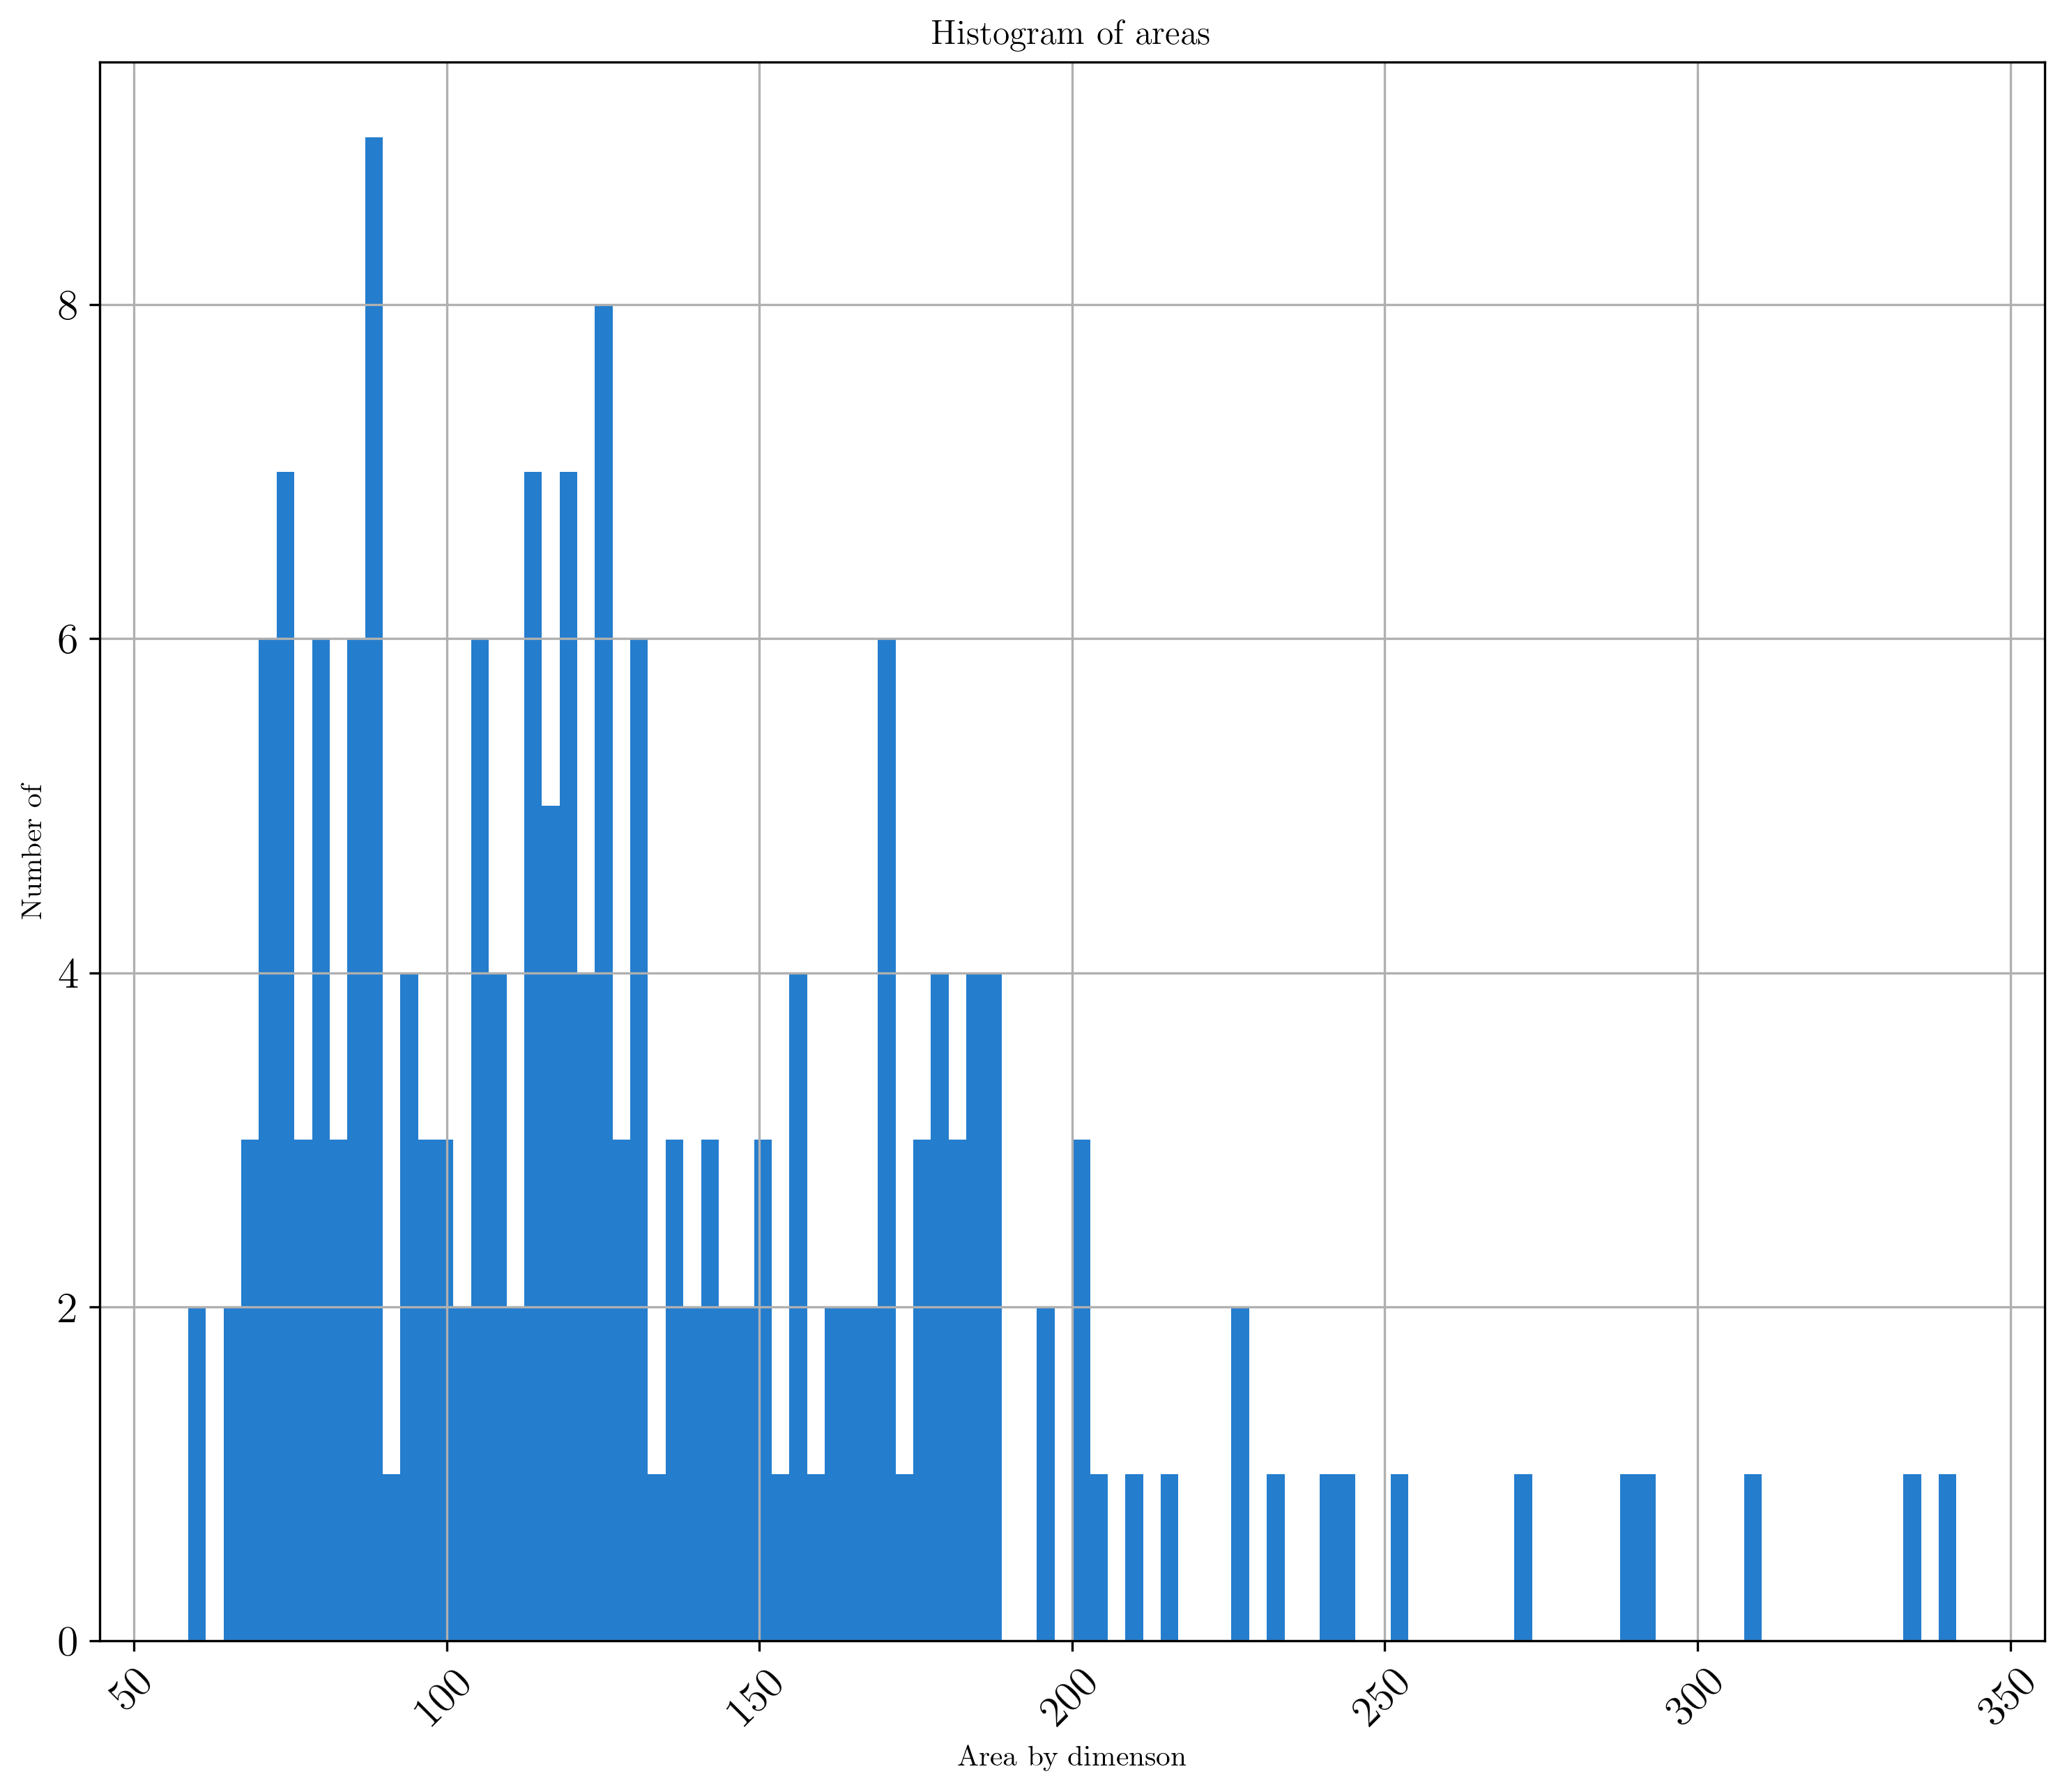

In [13]:
df_clean['perimeter'].plot(kind='hist',
        alpha=0.9,
        bins=100,
        title='Histogram of areas',
        rot=45,
        grid=True,
        figsize=(12,10),
        fontsize=15, 
        color=['#0c6fc8'])
plt.xlabel('Area by dimenson')
plt.ylabel("Number of ");

# Check interactively some plots

In [ ]:
num_frame = 1


df_inspect = df_clean[df_clean.index.str.contains('frame_'+ str(num_frame) + '_')]
img = reconstruct_df(df_inspect)

# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(img)
mask = img > threshold
labels = measure.label(mask)

fig = px.imshow(img, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'major_axis_length','minor_axis_length', 'perimeter', 'orientation']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label = props[index].label
    contour = measure.find_contours(labels == label, 0.4)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

fig


## Create a single image out of the stack

In [ ]:
def unite(array,tresh):
    """This function creates a single image by running along 
    all the stack and keeping only the pixels above a certain 
    treshold 
    
    Parameters
    ----------
    array : list of NUM images of size N x M  (NUM, N, M)
    tresh : int value 
   
    Returns
    ----------
    
    array : N x M 
    
    """
    
    size = np.shape(scaled_images_max[0])
    unite = np.zeros((size[0],size[1]))
    for k in range(len(array)):
        temp = np.where(array[k] > tresh)
        y, x = temp[0],temp[1] 
        yx = zip(y,x)
        for i, coord in enumerate(yx):
            unite[coord] = k+1
    return [unite]



In [ ]:
result = unite(scaled_images_max,90)
plt.imshow(result[0])
plt.colorbar()


## Convex Hull test

In [ ]:
button = widgets.Button(description="Next image!")
output = widgets.Output()
display(button, output)
counter_glob = 0 # Global variable for counter, this should not be done but ok I was in a hurry

#------------------------------#

frame_tresh = 0 

num_frame = 10

df_clean = list_df_clean[frame_tresh]
#df_inspect = df_clean[df_clean.index.str.contains('frame_'+ str(num_frame) + '_')]
#df_test = df_inspect['image']
df_test = df_top_larg['image']
len_df_test = len(df_test)


   
def convex(counter, len_df_test, df_test=df_test):
    from skimage.morphology import convex_hull_image, convex_hull_object   
    
    
    temp = df_test[counter]
    chull = convex_hull_object(temp)
    
    
    print(counter_glob)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()

    ax[0].set_title('Original picture')
    ax[0].imshow(df_test[counter], cmap=plt.cm.gray)
    ax[0].set_axis_off()

    ax[1].set_title('Transformed picture')
    ax[1].imshow(chull, cmap=plt.cm.gray)
    ax[1].set_axis_off()

    fig.canvas.draw()
    
    

def on_button_clicked(b):
    import sys
    
    
    
    global counter_glob, num_frame
    with output:
        convex(counter_glob,num_frame,df_test)
        counter_glob += 1
        
        if counter_glob == len_df_test:
            print("images done, restarting")
            counter_glob = 0
       

button.on_click(on_button_clicked)

# Example of how to show top n biggest areas

In [ ]:
parameter = 'minor_axis_length'   

df_top_larg = df_clean.nlargest(20,parameter).copy()
df_top_small = df_clean.nsmallest(20,parameter).copy()
result_top_larg, result_top_small = reconstruct_df(df_top_larg), reconstruct_df(df_top_small)
plt.imshow(result_top_larg)
plt.show()
plt.imshow(result_top_small)
plt.show()

In [ ]:
df_top_larg['major_axis_length'].plot(kind='hist',
        alpha=0.9,
        bins=100,
        title='Histogram of areas',
        rot=45,
        grid=True,
        figsize=(12,10),
        fontsize=15, 
        color=['#0c6fc8'])
plt.xlabel('Area by dimenson')
plt.ylabel("Number of ");